# Variational Autoencoder

In this notebook, a variational autoencoder (VAE) is trained that can generate images of fashion items. For more information about VAEs, we refer to https://www.ibm.com/think/topics/variational-autoencoder.

## Imports

In [1]:
import torch
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

## Set Device

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Data Loading

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.FashionMNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.FashionMNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.8MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 202kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.79MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 27.1MB/s]

Training samples: 60000
Test samples: 10000


## Encoder

The encoder consists of a convolutional neural network that maps an input image to the parameters of a multivariate normal distribution in latent space. Concretely, it produces a mean vector together with the logarithm of the diagonal elements of the covariance matrix, thereby defining a Gaussian distribution with independent latent dimensions. This parameterization enables stochastic sampling from the latent space.

In [4]:
class Encoder(torch.nn.Module):
    def __init__(self, latent_dim: int):
        super(Encoder, self).__init__()

        self.conv1 = torch.nn.Conv2d(1, 8, 3)
        self.conv2 = torch.nn.Conv2d(8, 16, 3)
        self.conv3 = torch.nn.Conv2d(16, 32, 3)
        self.conv4 = torch.nn.Conv2d(32, 64, 3)

        self.linear1 = torch.nn.LazyLinear(256)
        self.linear2 = torch.nn.LazyLinear(128)
        self.mean = torch.nn.Linear(128, latent_dim)
        self.var = torch.nn.Linear(128, latent_dim)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(F.relu(self.conv4(x)), (2, 2))

        x = torch.flatten(x, 1) # Do not flatten batch dimension

        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))

        mean_vec = self.mean(x)
        log_var_vec = self.var(x)

        return mean_vec, log_var_vec

## Decoder

The decoder takes a vector from the latent space and reconstructs a fashion MNIST image.

In [5]:
class Decoder(torch.nn.Module):
    def __init__(self, latent_dim: int):
        super(Decoder, self).__init__()

        self.linear1 = torch.nn.Linear(latent_dim, 128 * 8 * 8)
        self.unflat = torch.nn.Unflatten(1, (128, 8, 8))
        # See: https://indico.cern.ch/event/996880/contributions/4188468/attachments/2193001/3706891/ChiakiYanagisawa_20210219_Conv2d_and_ConvTransposed2d.pdf
        self.conv_tran1 = torch.nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2, padding=0) # out 16x16
        self.conv_tran2 = torch.nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=0, dilation=2) # out 20x20
        self.conv_tran3 = torch.nn.ConvTranspose2d(32, 16, kernel_size=3, stride=1, padding=0, dilation=2) # out 24x24
        self.conv_tran4 = torch.nn.ConvTranspose2d(16, 1, kernel_size=3, stride=1, padding=0, dilation=2) # out 28x28

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = self.unflat(x)
        x = F.relu(self.conv_tran1(x))
        x = F.relu(self.conv_tran2(x))
        x = F.relu(self.conv_tran3(x))

        # Why doing a ReLU after this breaks everyting?
        x = self.conv_tran4(x)

        return x

## Loss

The loss consists of two terms: a reconstruction term, implemented as MSE, and a Kullback-Leibler divergence term that regularizes the latent distribution by encouraging it to match the prior.

In [6]:
def vae_loss(recon_x, x, mean, log_var):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')

    # KL divergence term
    # KL(N(mu, sigma) || N(0,1)) = 0.5 * sum( exp(log_var) + mu^2 - 1 - log_var )
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

    # Total loss
    return recon_loss + KLD


## Training

In [7]:
def show_reconstructions(original_imgs, reconstructed_imgs, n=5, title=None):
    #Display original and reconstructed images side by side.
    original_imgs = original_imgs[:n]
    reconstructed_imgs = reconstructed_imgs[:n]

    fig, axes = plt.subplots(2, n, figsize=(n*2.5, 5))
    if title is not None:
        fig.suptitle(title, fontsize=16)

    for i in range(n):
        # Original
        axes[0, i].imshow(original_imgs[i].cpu().squeeze(), cmap='gray')
        axes[0, i].axis('off')

        # Reconstructed
        axes[1, i].imshow(reconstructed_imgs[i].detach().cpu().squeeze(), cmap='gray')
        axes[1, i].axis('off')

    axes[0,0].set_ylabel('Original', fontsize=12)
    axes[1,0].set_ylabel('Reconstructed', fontsize=12)
    plt.show()


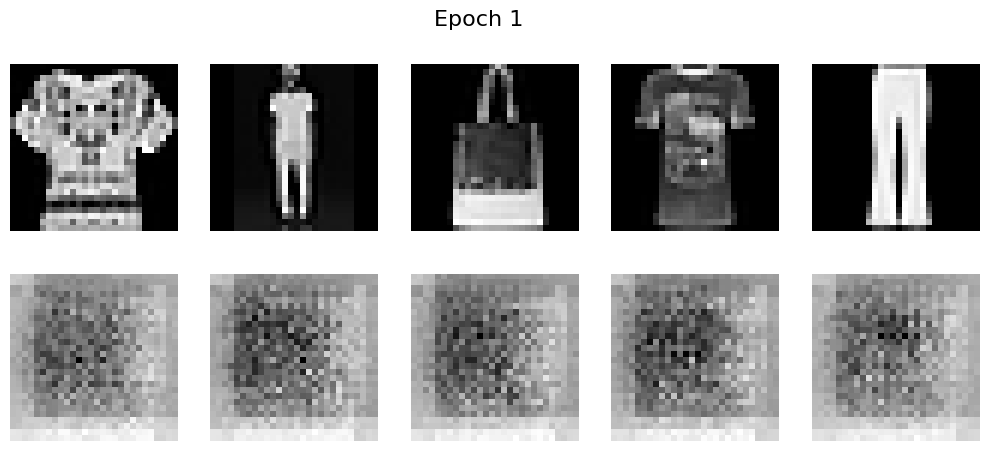

Epoch 1, Loss: 8919874.278564453


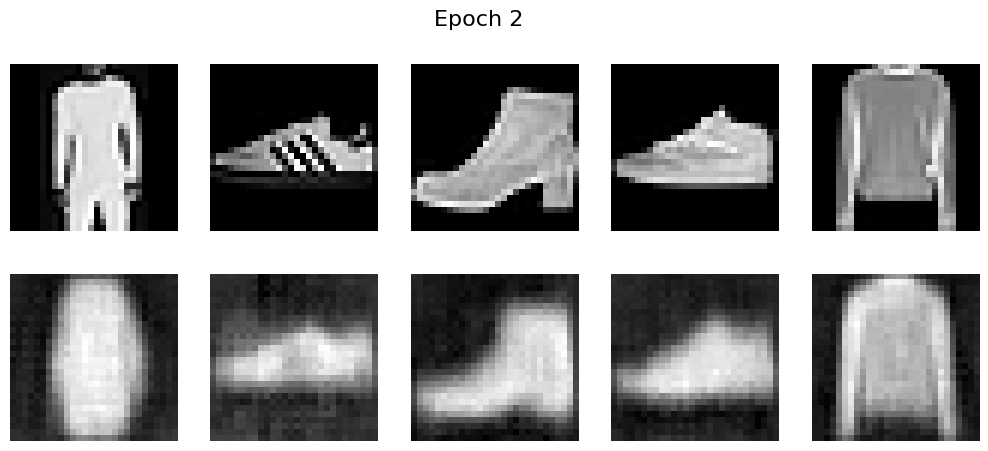

Epoch 2, Loss: 5406752.614990234


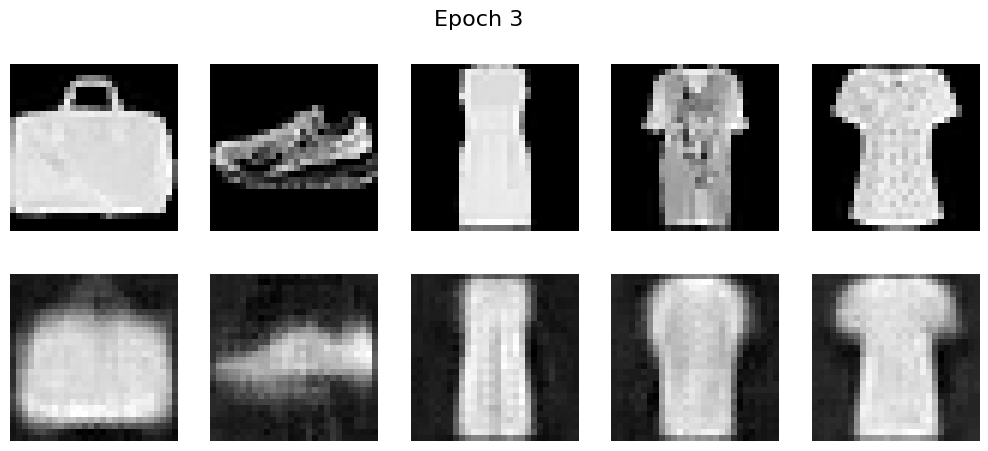

Epoch 3, Loss: 4774063.326171875


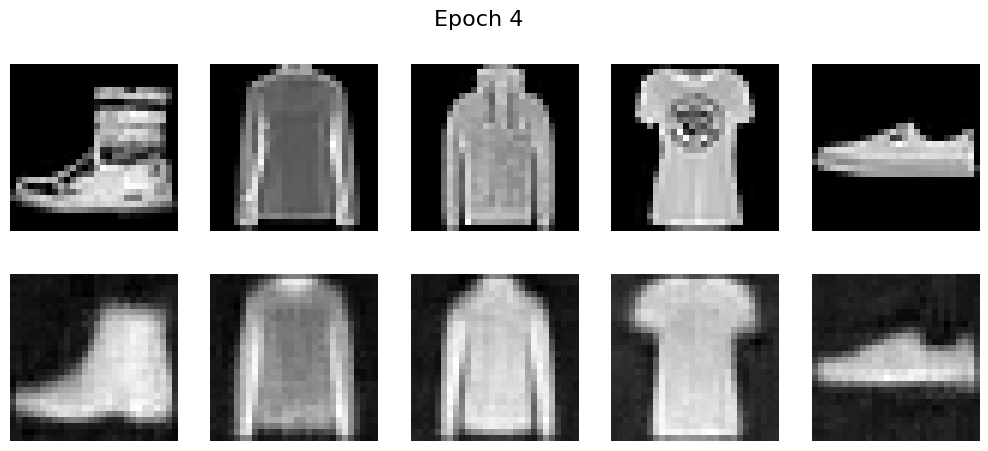

Epoch 4, Loss: 4480629.974121094


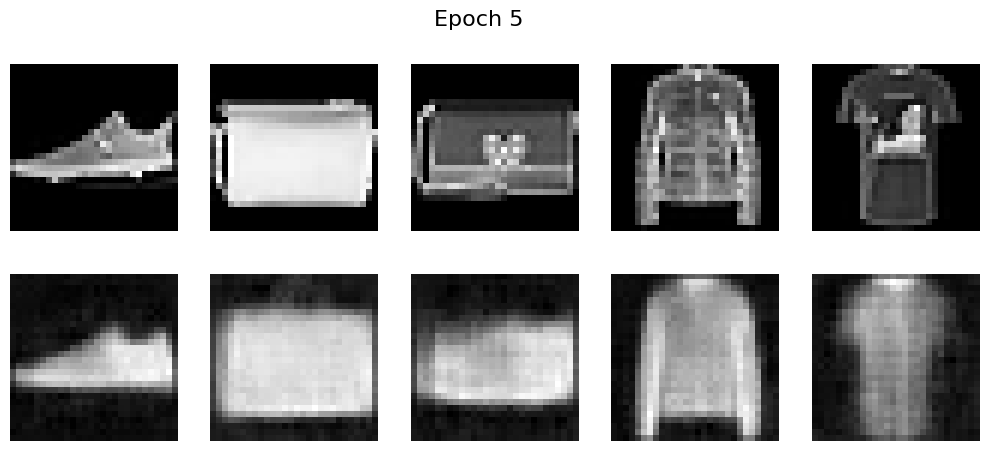

Epoch 5, Loss: 4279880.386962891


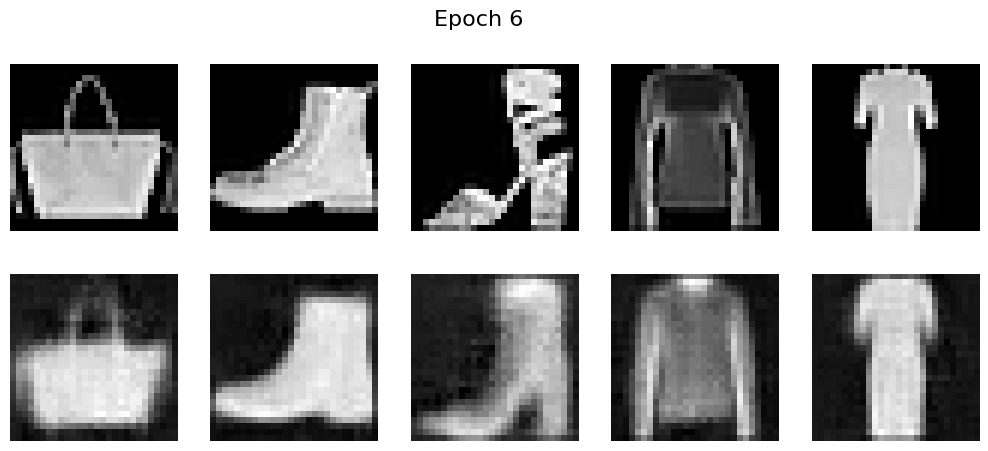

Epoch 6, Loss: 4147013.3911132812


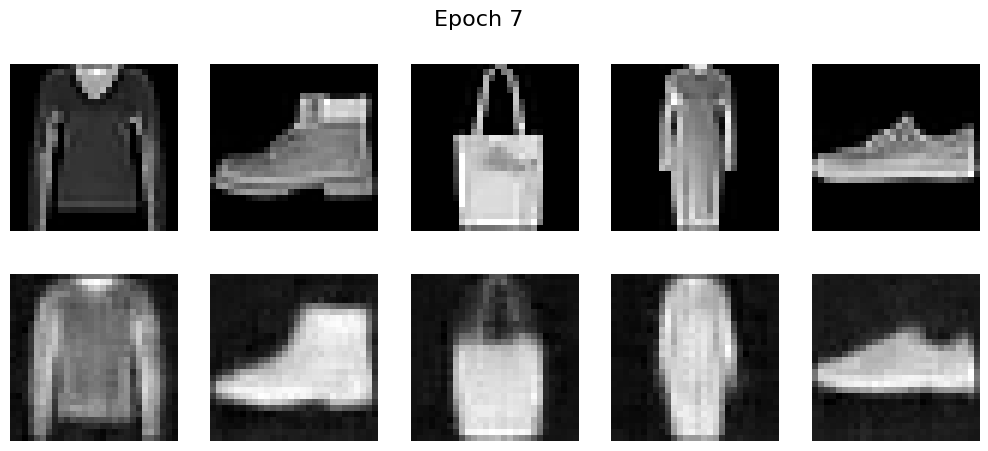

Epoch 7, Loss: 4058702.0078125


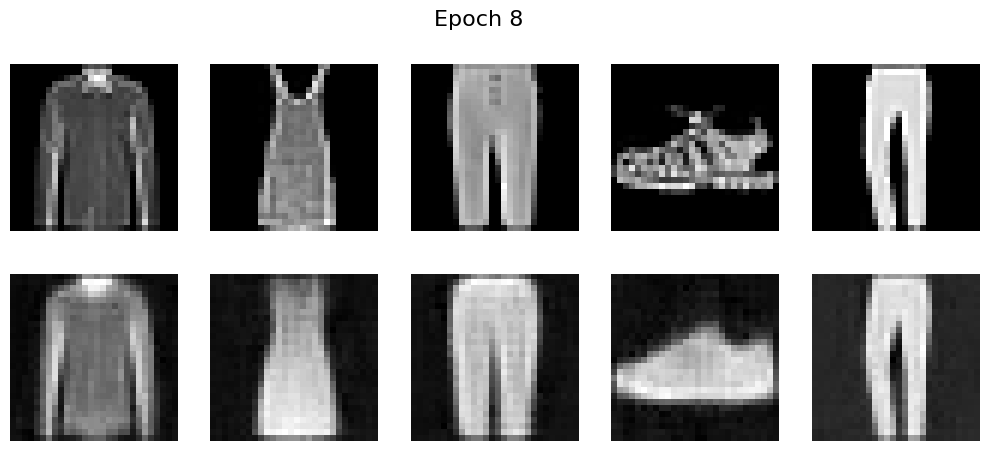

Epoch 8, Loss: 3975213.6677246094


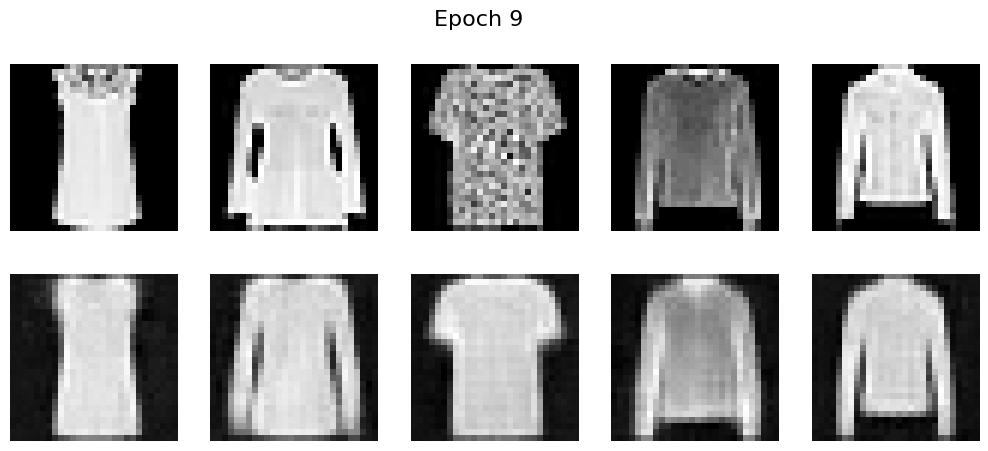

Epoch 9, Loss: 3916161.2775878906


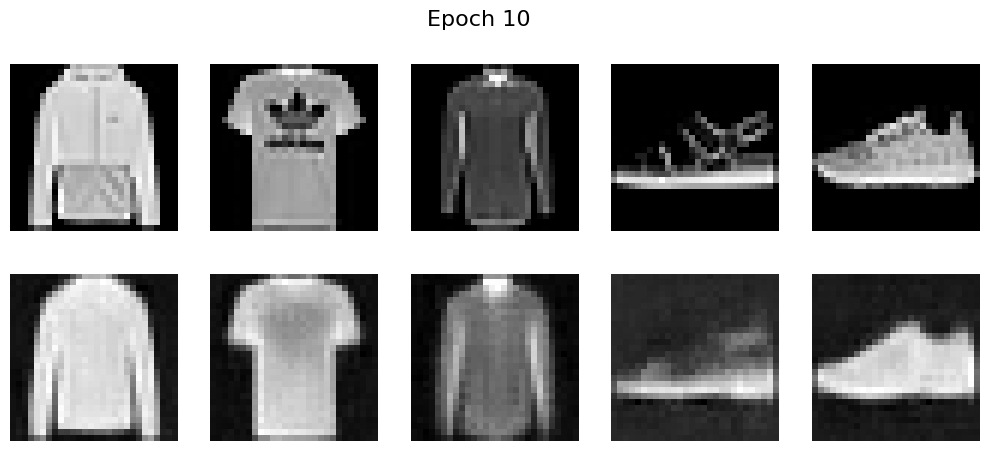

Epoch 10, Loss: 3865201.941040039


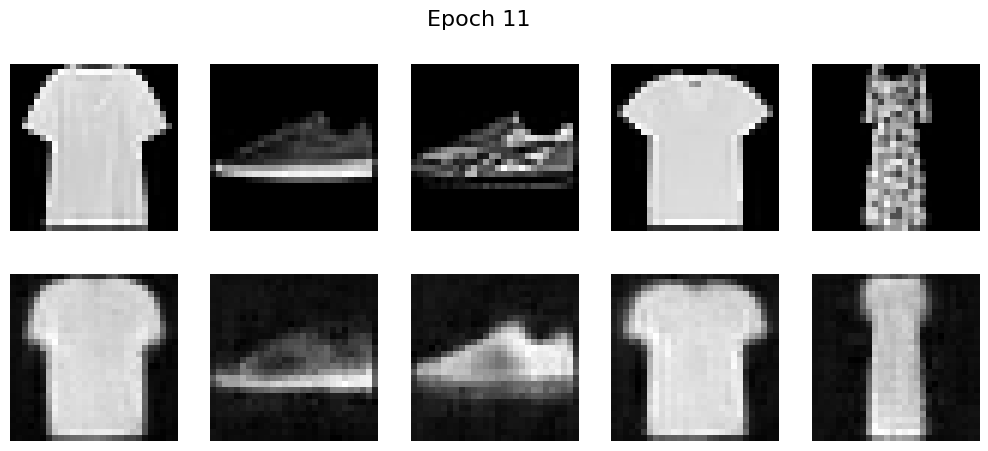

Epoch 11, Loss: 3823826.260986328


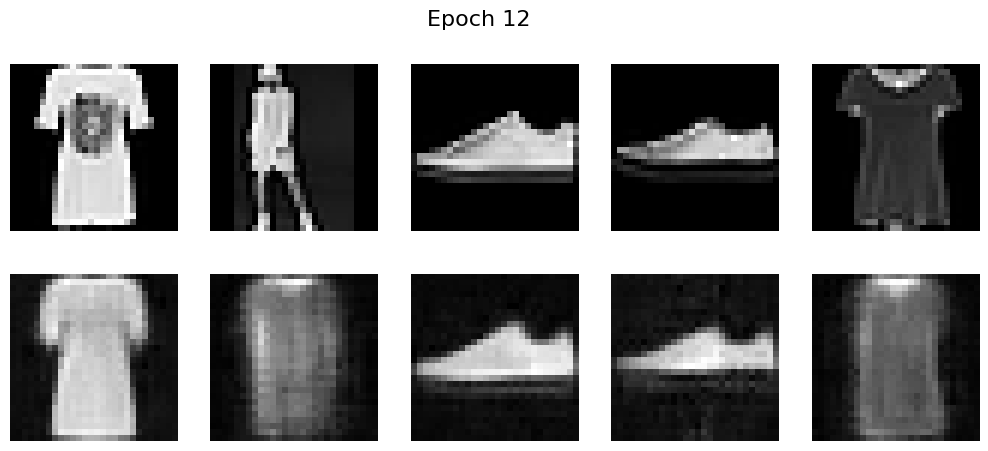

Epoch 12, Loss: 3788446.0689697266


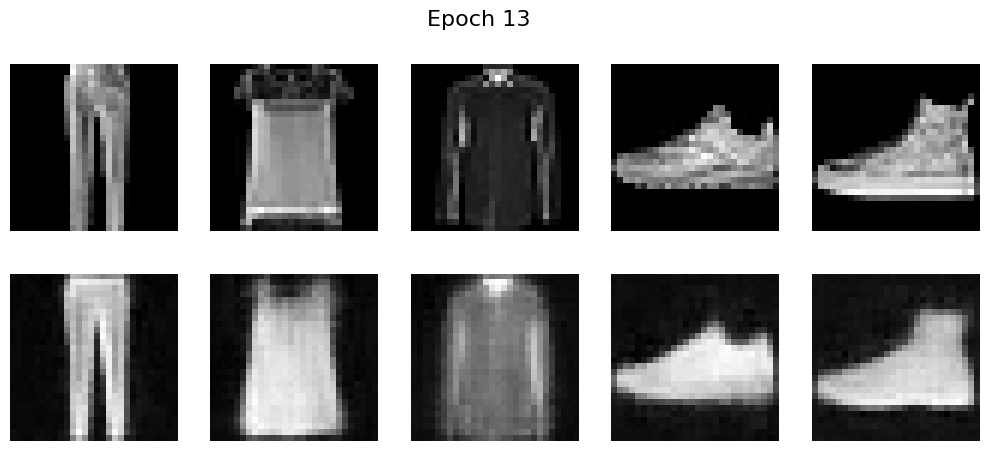

Epoch 13, Loss: 3754452.8811035156


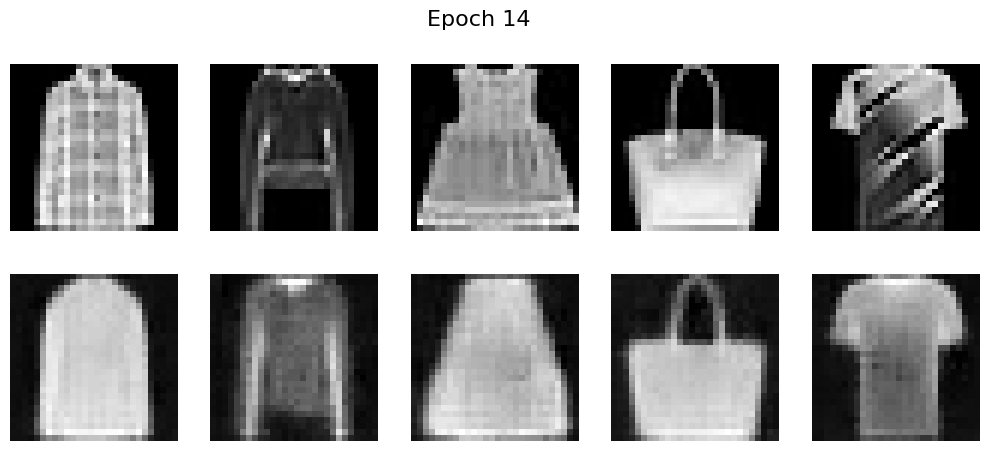

Epoch 14, Loss: 3726881.6030273438


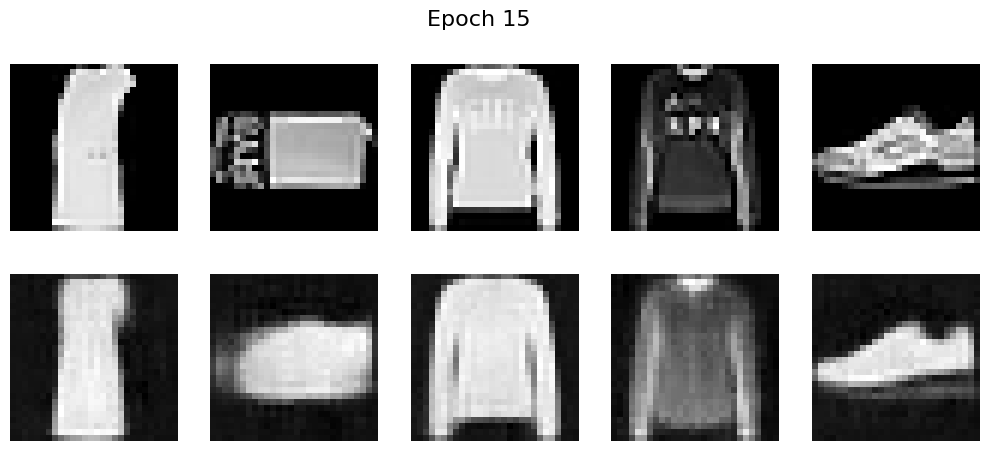

Epoch 15, Loss: 3696174.468017578


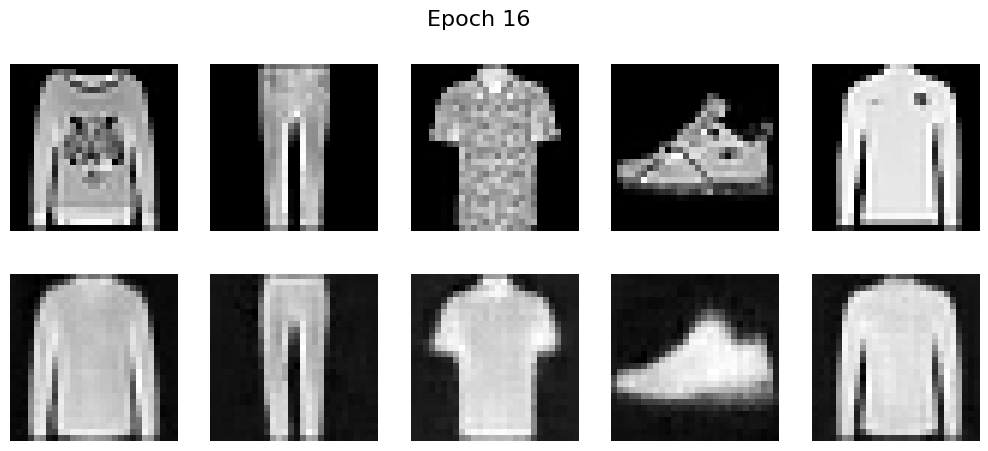

Epoch 16, Loss: 3677822.0283203125


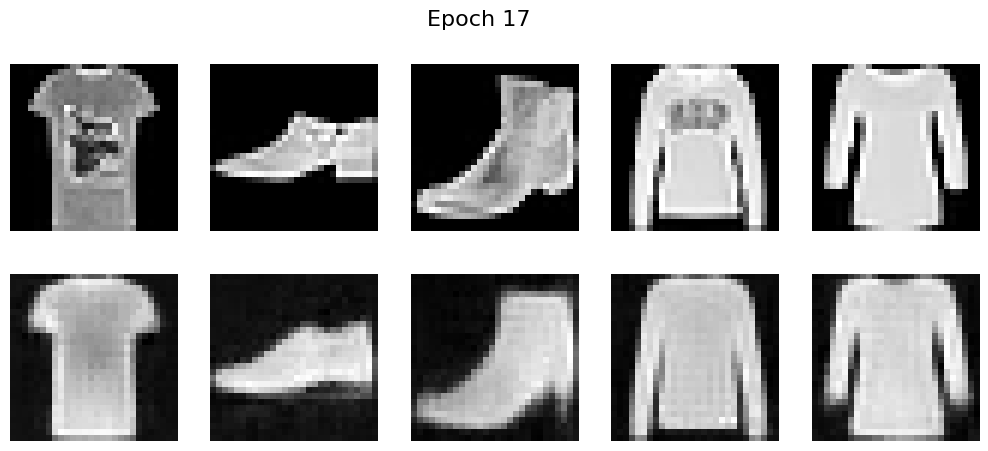

Epoch 17, Loss: 3660712.4635009766


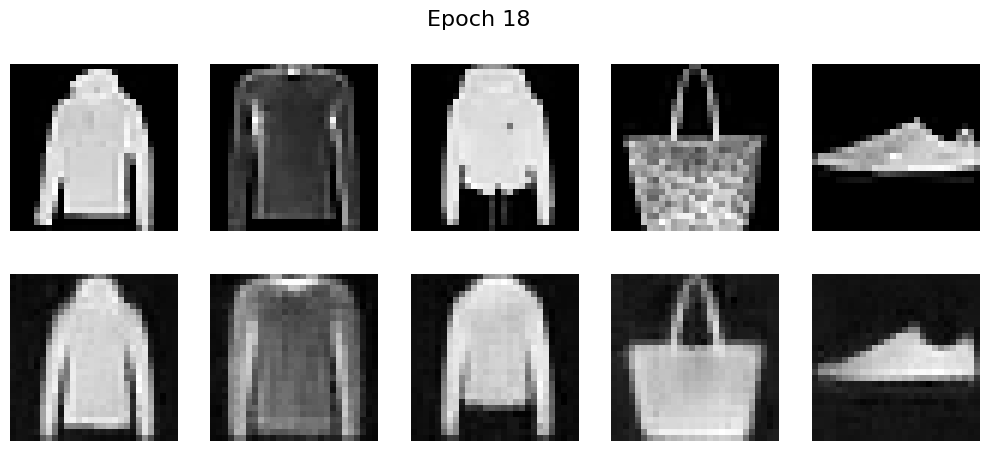

Epoch 18, Loss: 3641873.6833496094


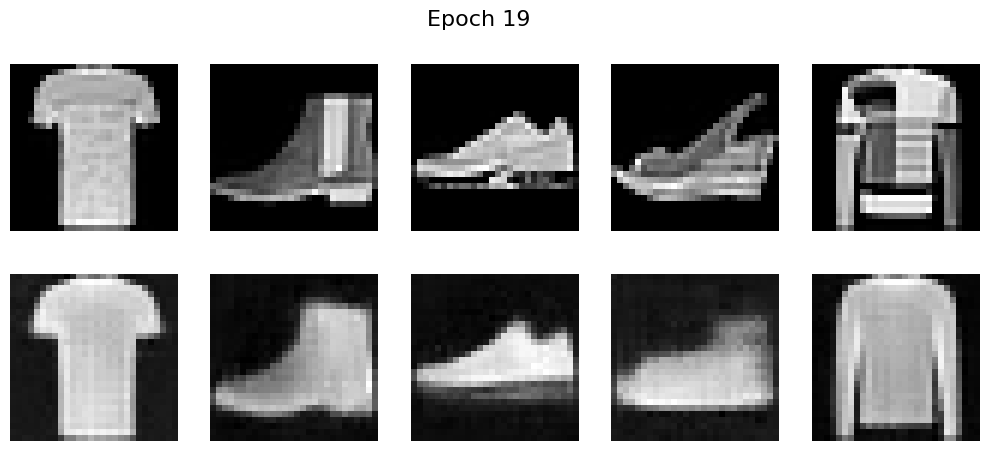

Epoch 19, Loss: 3630736.59375


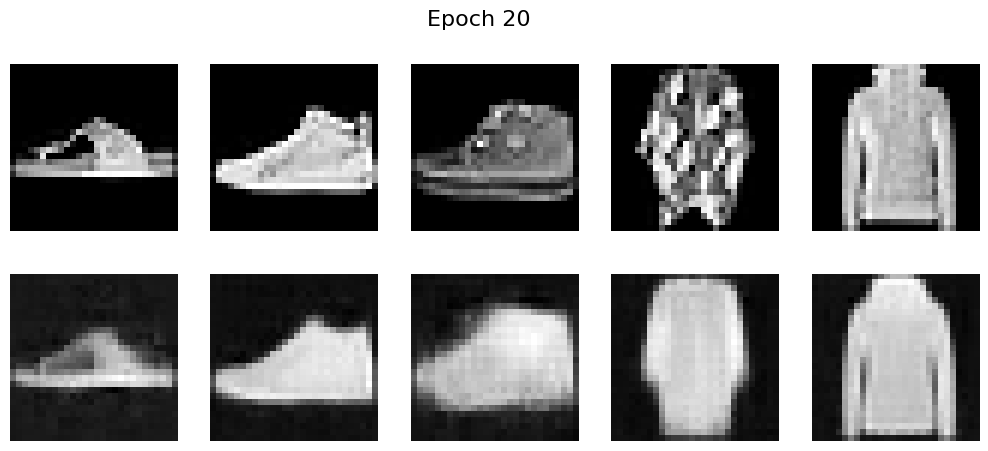

Epoch 20, Loss: 3611135.6240234375


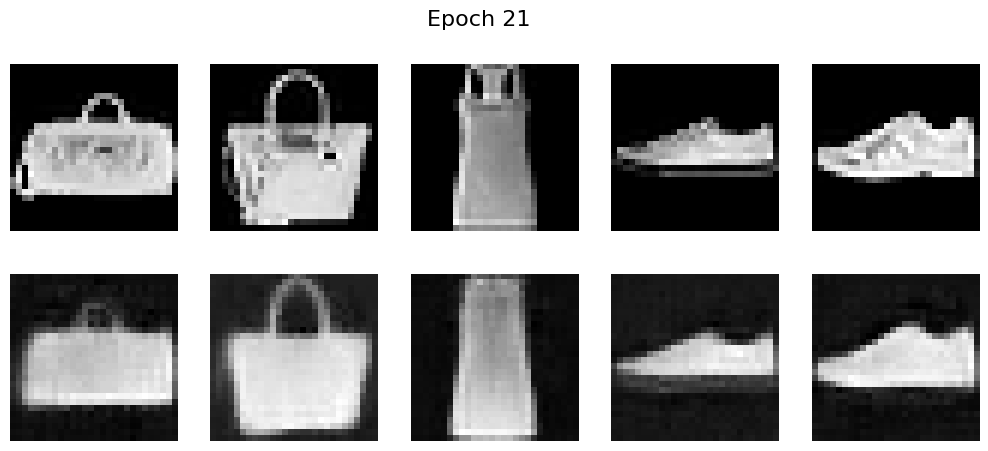

Epoch 21, Loss: 3601117.14453125


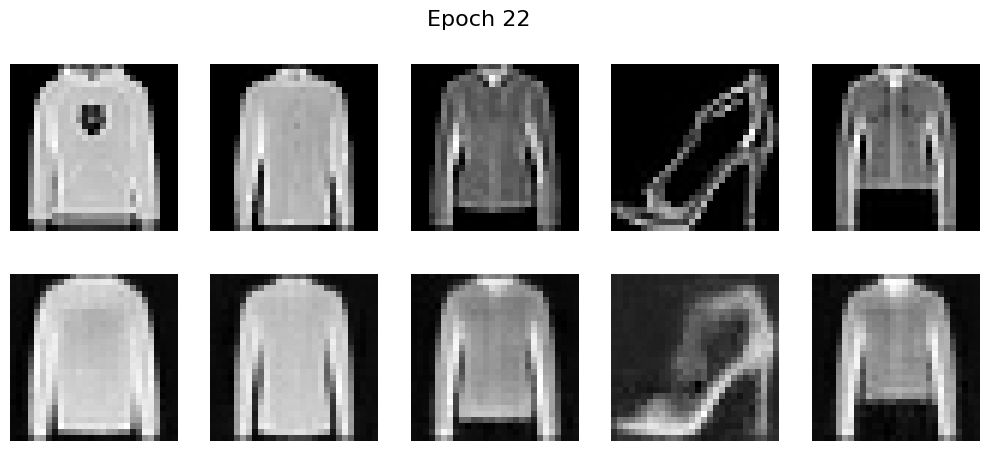

Epoch 22, Loss: 3586709.760498047


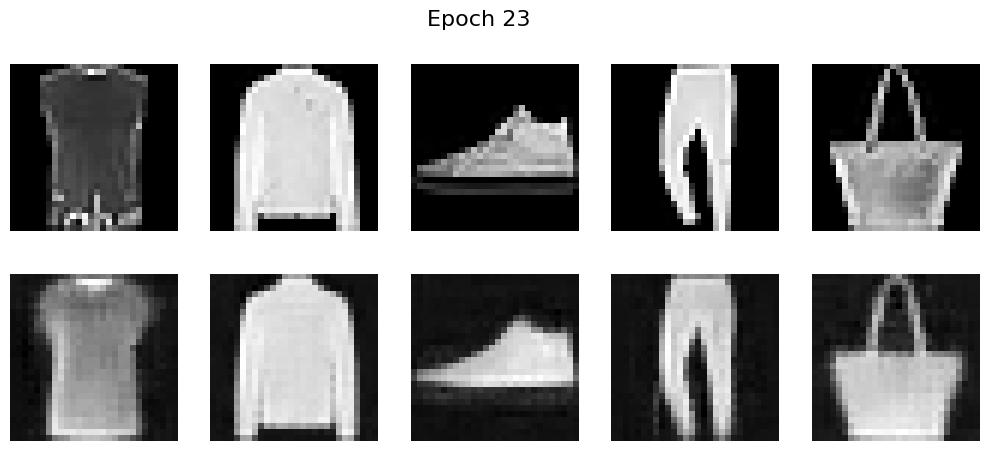

Epoch 23, Loss: 3574787.7185058594


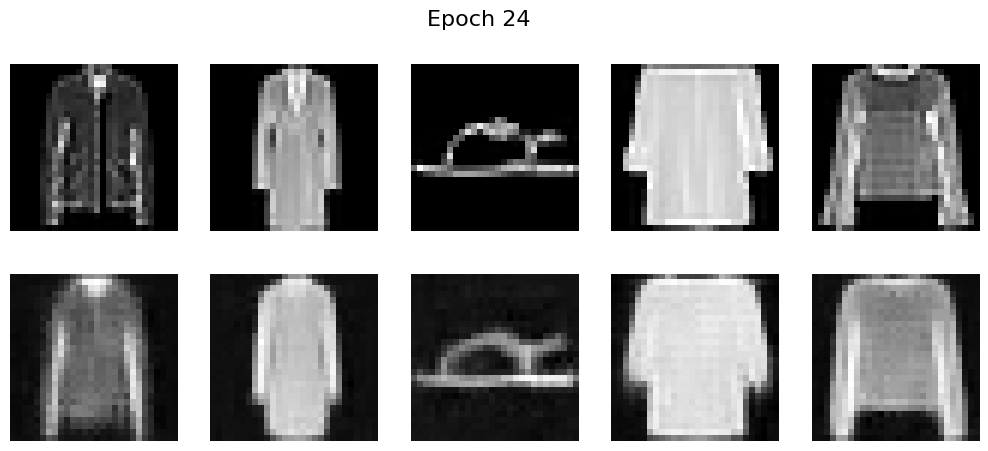

Epoch 24, Loss: 3565722.034790039


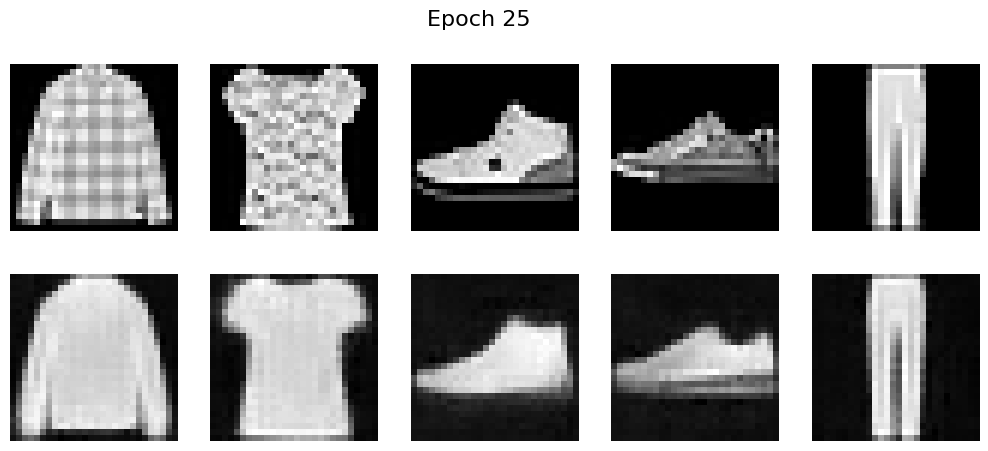

Epoch 25, Loss: 3558619.9809570312


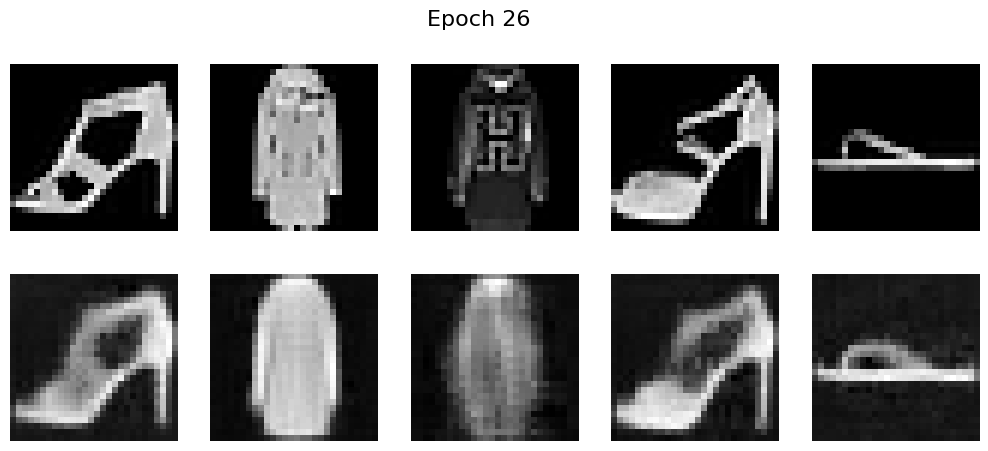

Epoch 26, Loss: 3545237.0725097656


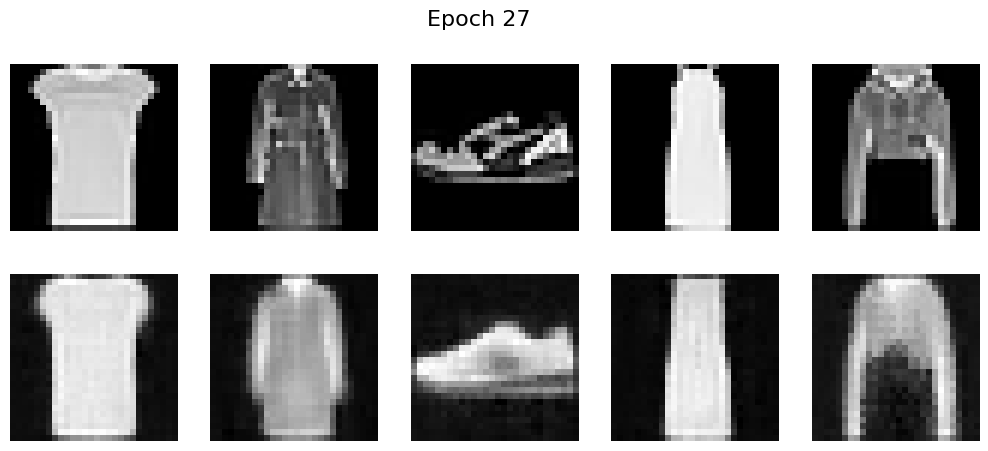

Epoch 27, Loss: 3538348.8864746094


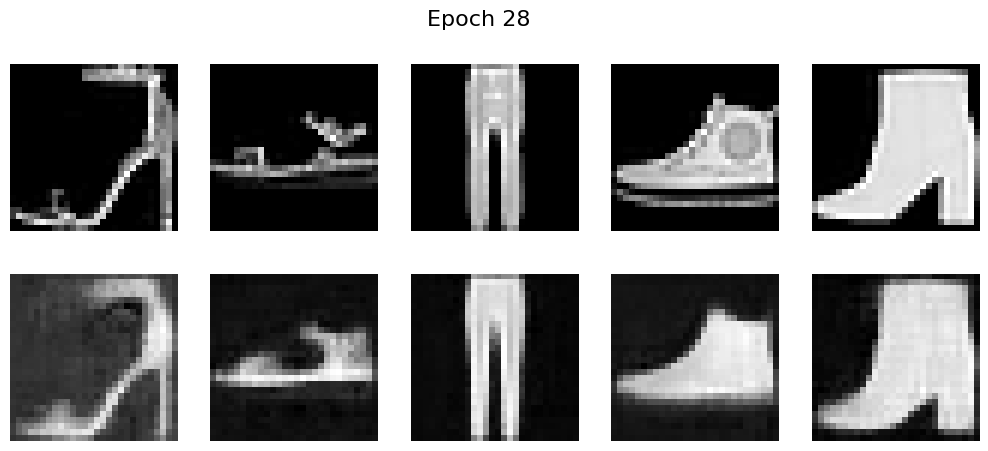

Epoch 28, Loss: 3531731.31640625


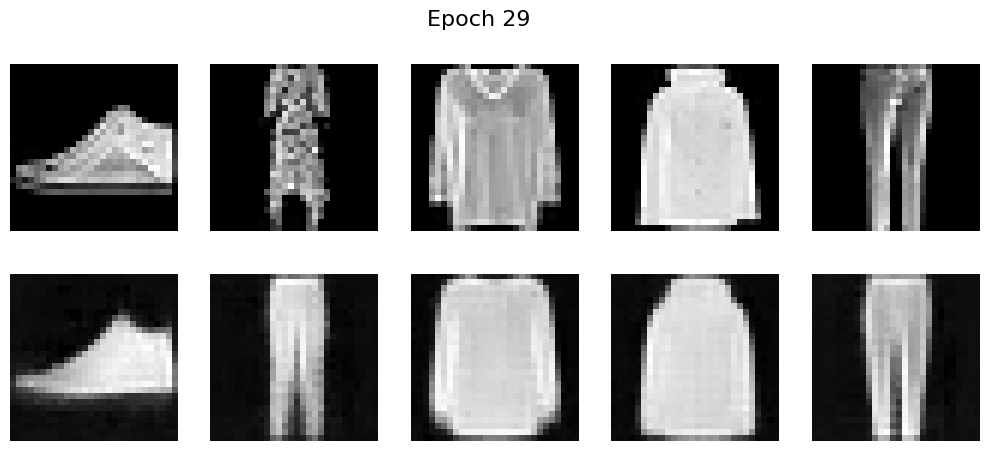

Epoch 29, Loss: 3525945.2282714844


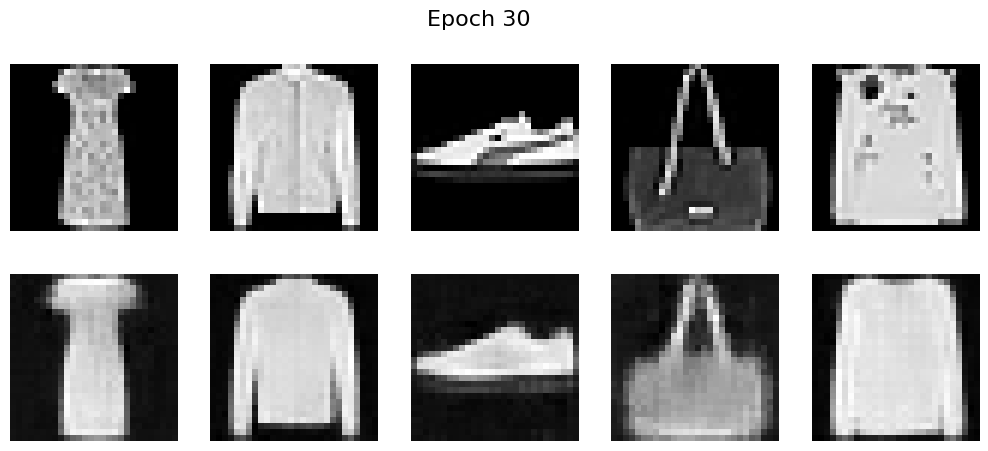

Epoch 30, Loss: 3517507.9096679688


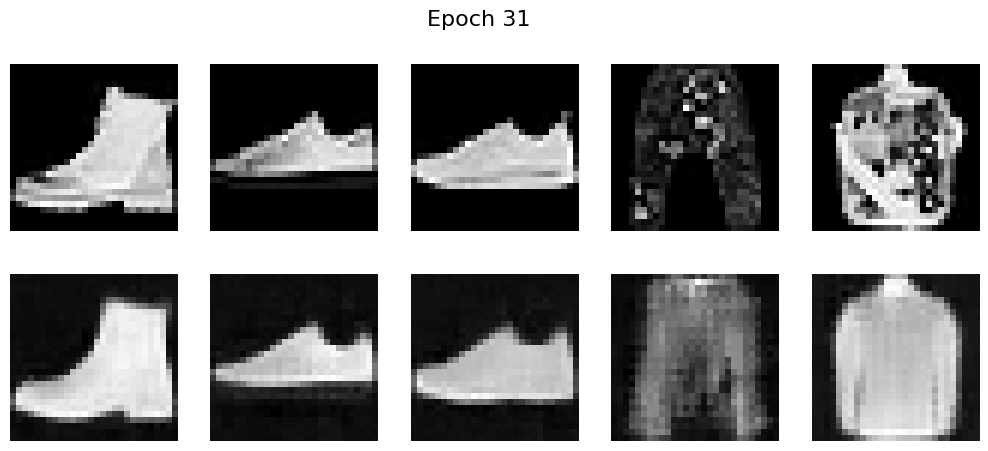

Epoch 31, Loss: 3511183.518798828


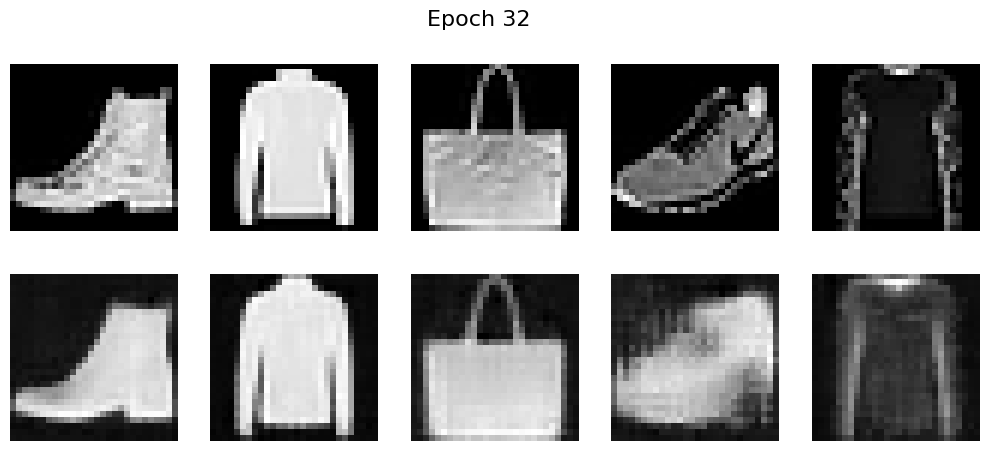

Epoch 32, Loss: 3504092.2779541016


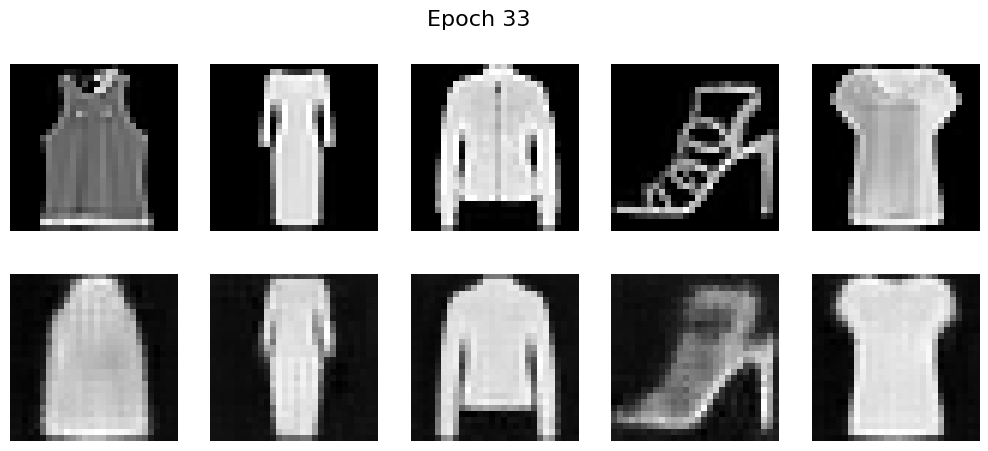

Epoch 33, Loss: 3502206.541748047


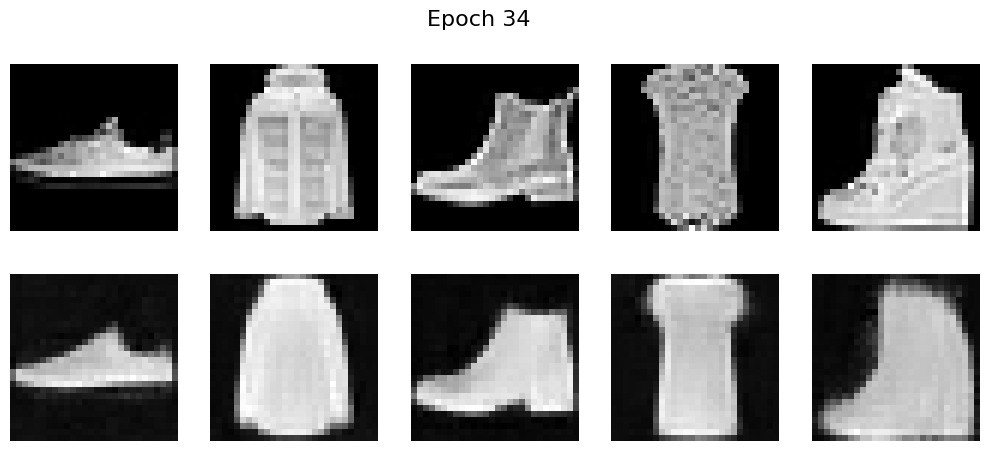

Epoch 34, Loss: 3494209.276611328


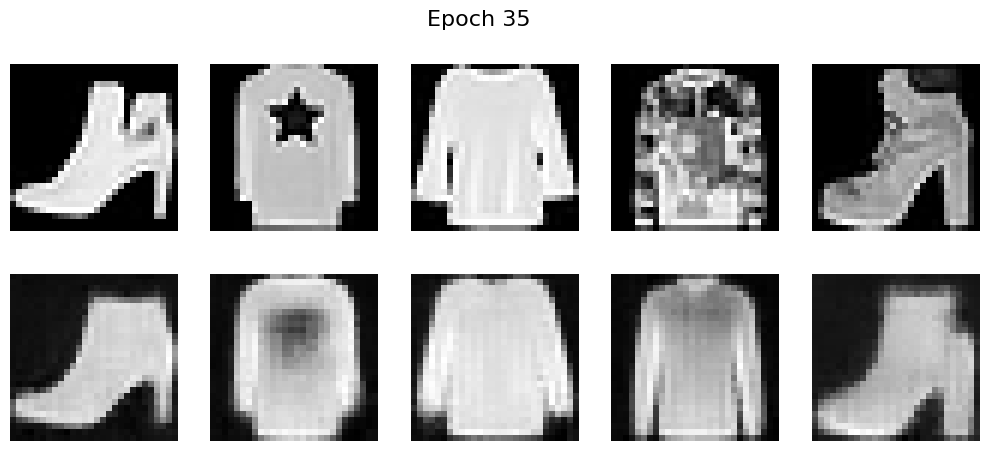

Epoch 35, Loss: 3488352.6411132812


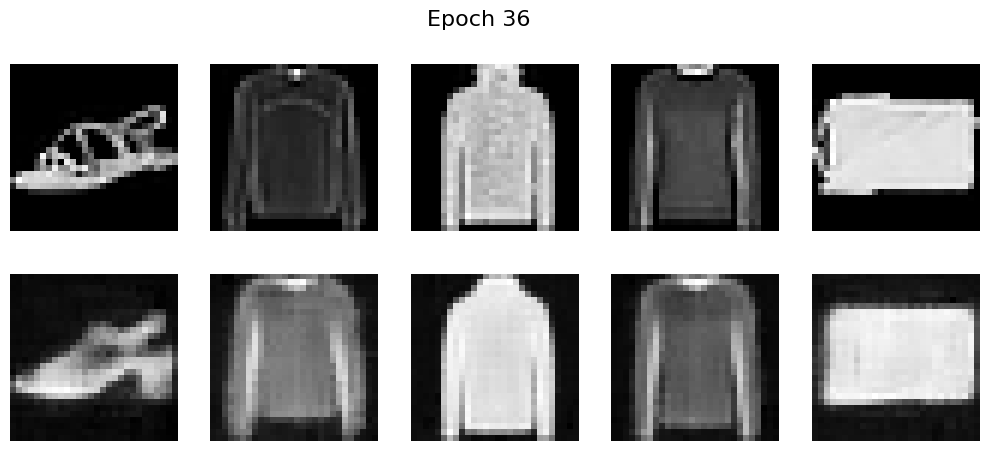

Epoch 36, Loss: 3487059.6772460938


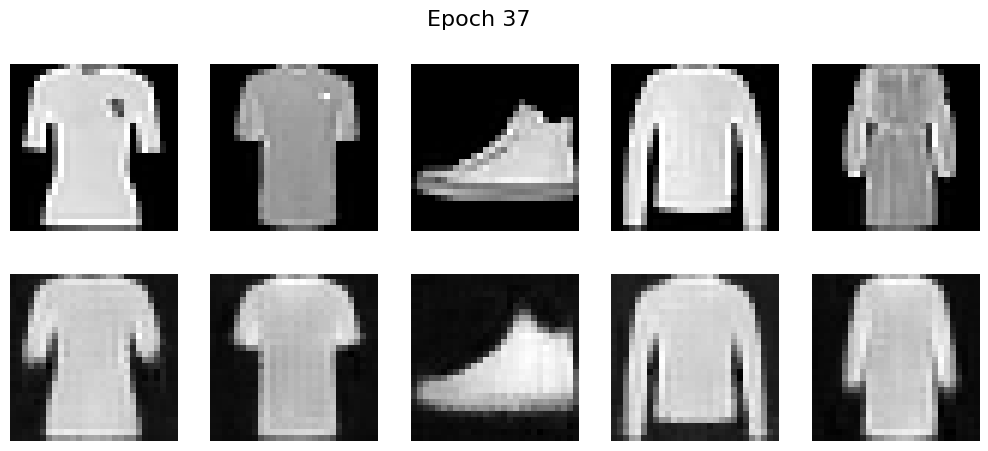

Epoch 37, Loss: 3476308.1955566406


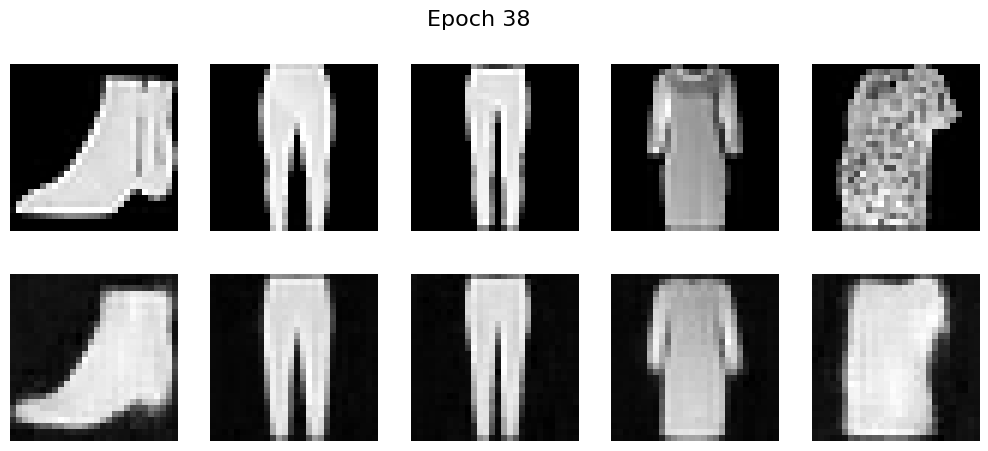

Epoch 38, Loss: 3471140.3608398438


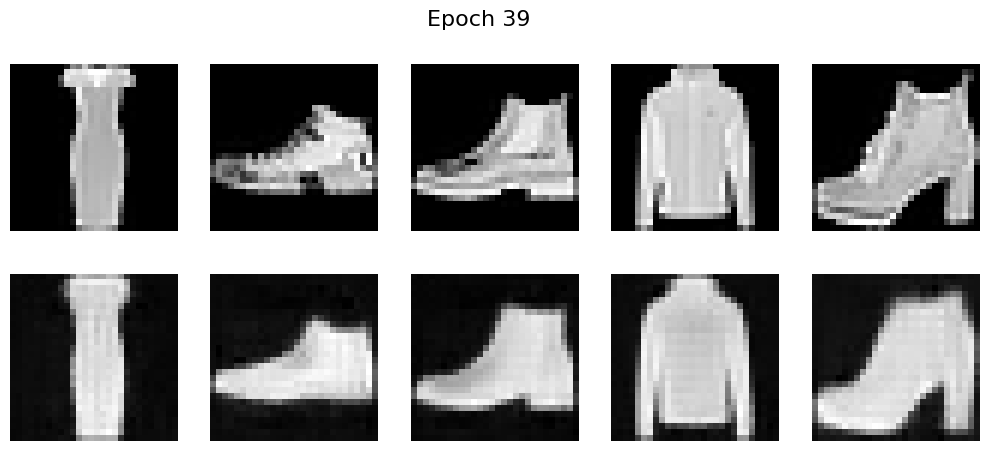

Epoch 39, Loss: 3467569.532348633


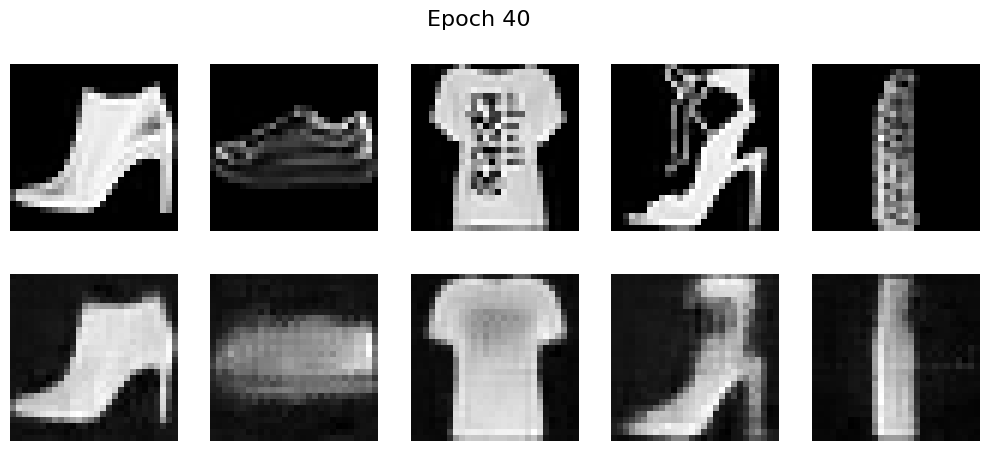

Epoch 40, Loss: 3464465.52734375


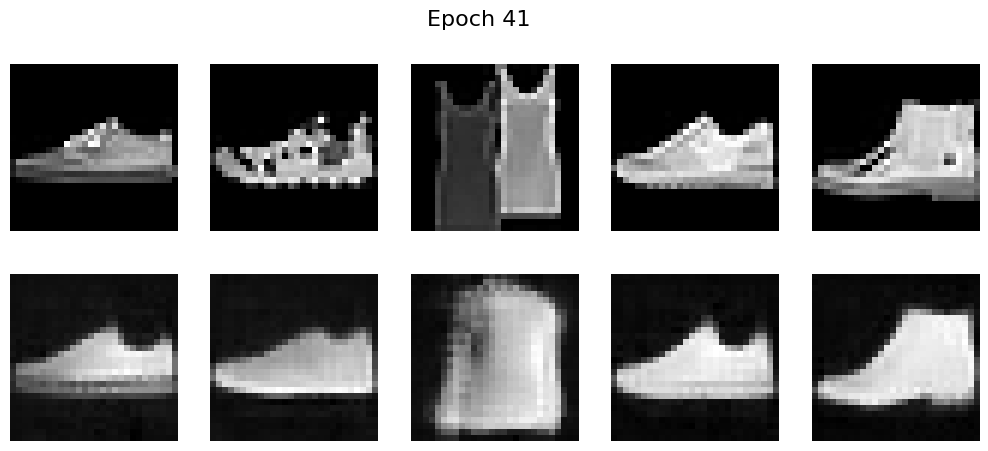

Epoch 41, Loss: 3462790.3381347656


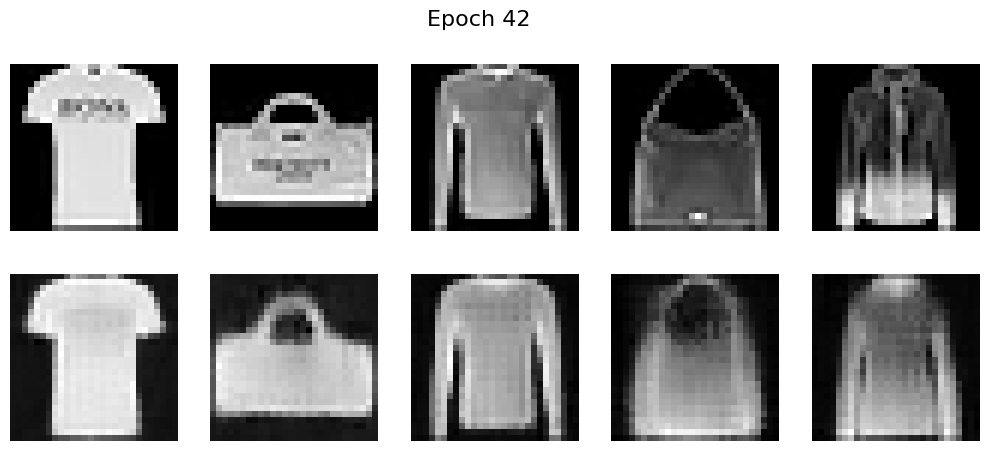

Epoch 42, Loss: 3454487.7170410156


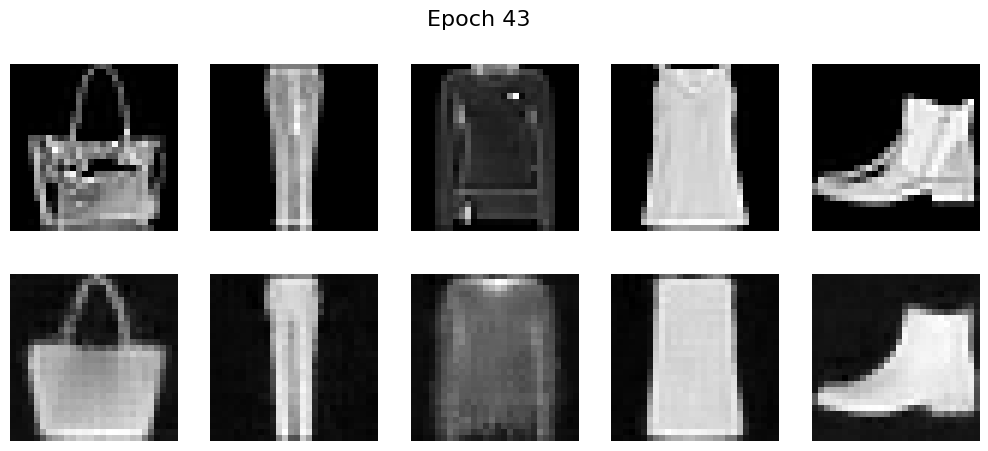

Epoch 43, Loss: 3453054.542236328


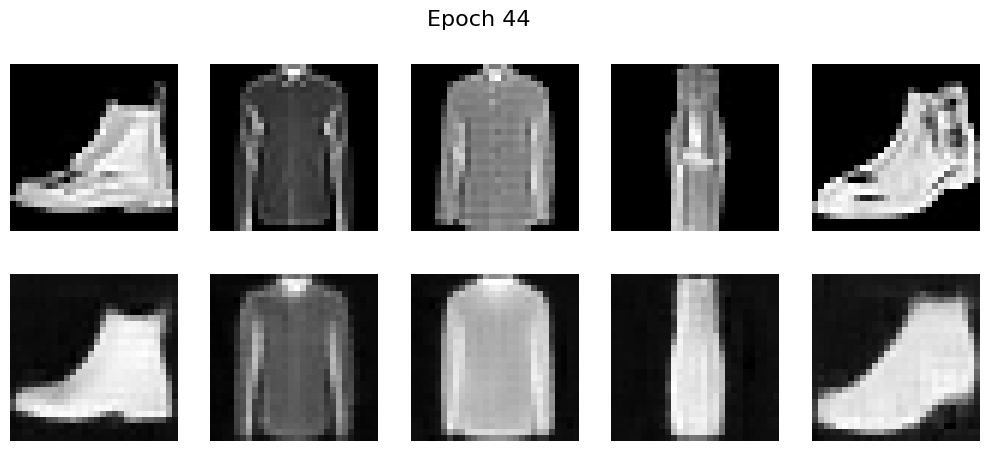

Epoch 44, Loss: 3447715.350830078


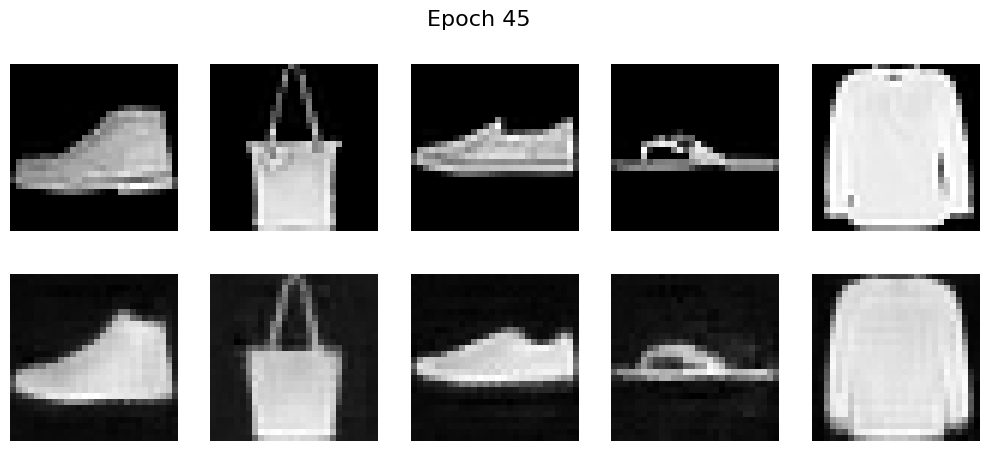

Epoch 45, Loss: 3442950.5893554688


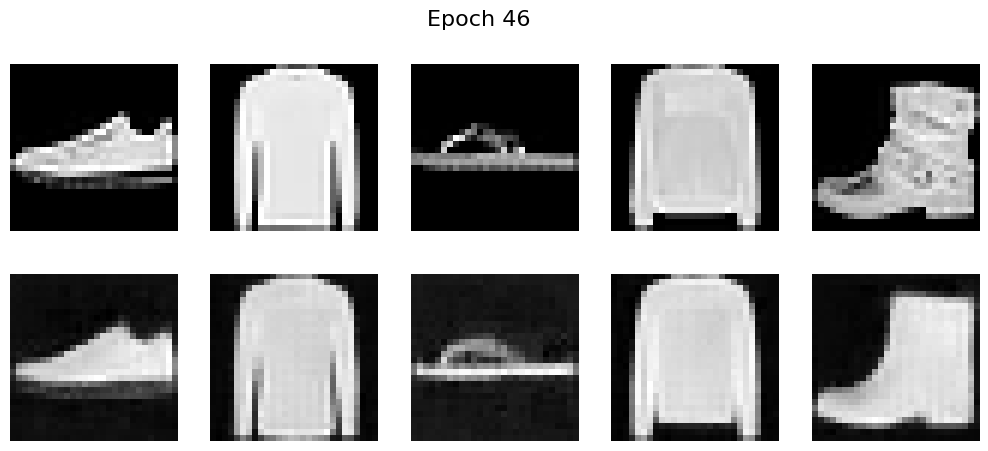

Epoch 46, Loss: 3442081.003173828


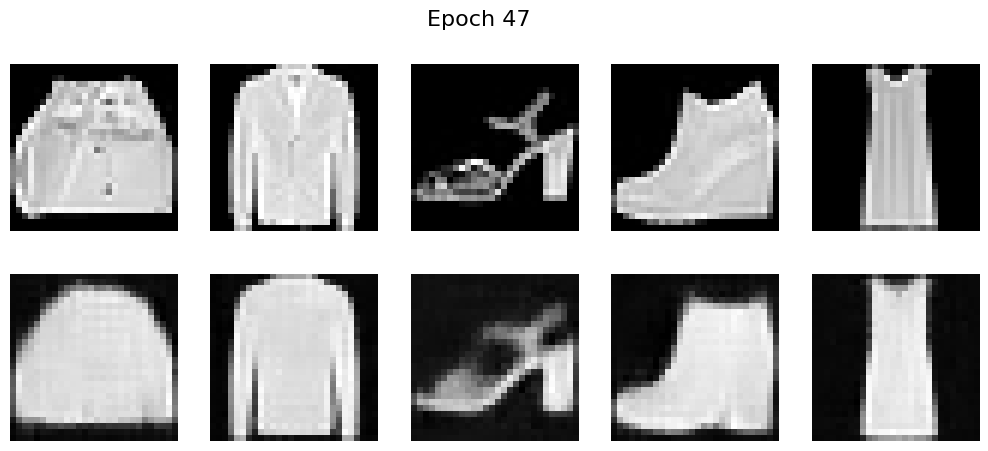

Epoch 47, Loss: 3438422.1923828125


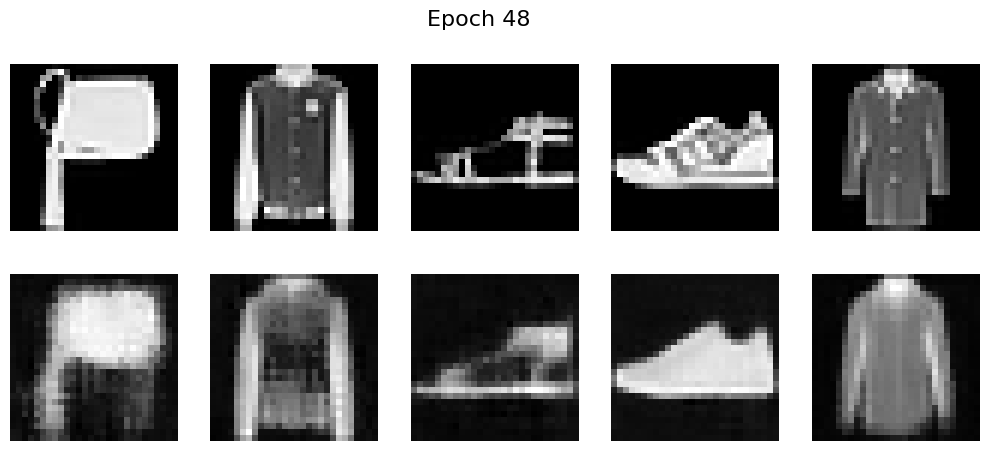

Epoch 48, Loss: 3436438.3881835938


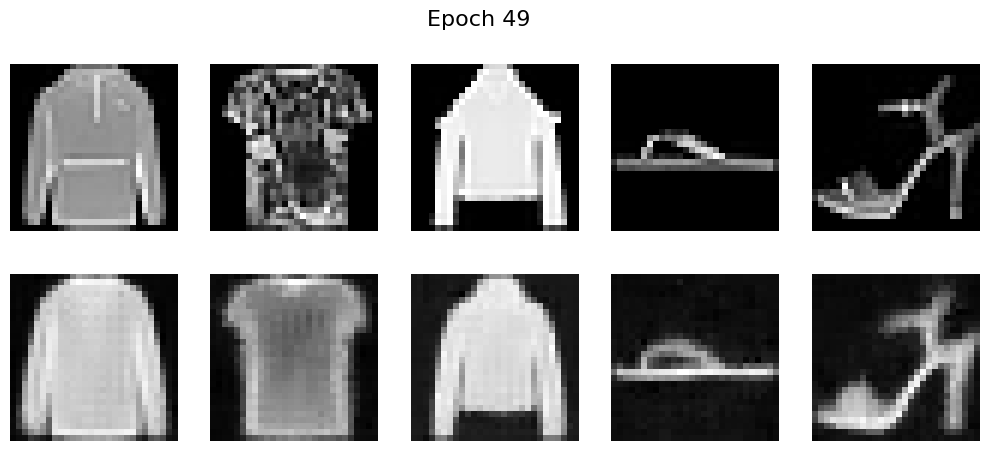

Epoch 49, Loss: 3430495.7124023438


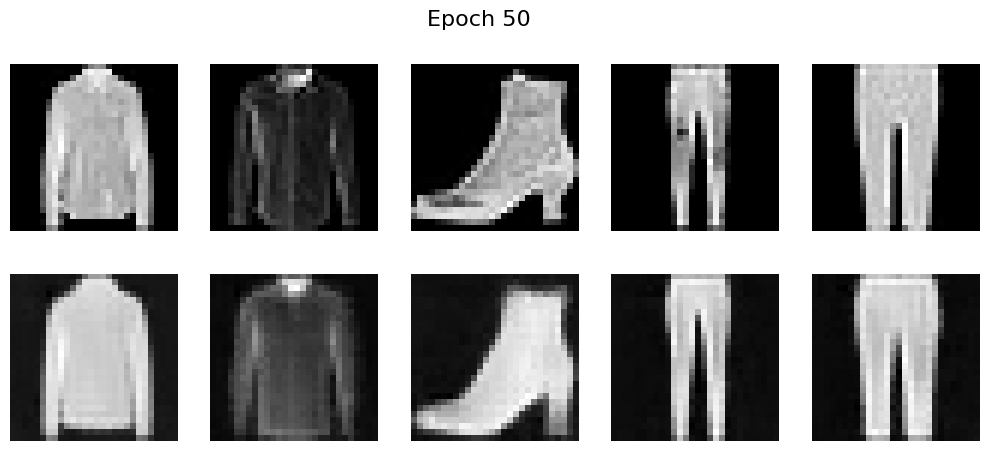

Epoch 50, Loss: 3427118.5209960938


In [8]:
latent_dim = 32

encoder = Encoder(latent_dim)
encoder.to(device)
decoder = Decoder(latent_dim)
decoder.to(device)

epochs = 50
optimizer = optim.Adam(
    list(encoder.parameters()) + list(decoder.parameters()),
    lr=0.001
)

for epoch in range(1, epochs + 1):
    total_loss = 0
    for batch_index, (img, _) in enumerate(train_loader):
        img = img.to(device)

        mean_vec, log_var_vec = encoder(img)
        std = torch.exp(0.5 * log_var_vec)    # standard deviation

        # sample epsilon from standard normal
        epsilon = torch.randn_like(std)

        # reparameterization trick
        z = mean_vec + epsilon * std

        output = decoder(z)

        if batch_index == 0:
          show_reconstructions(img, output, n=5, title=f'Epoch {epoch}')

        loss = vae_loss(output, img, mean_vec, log_var_vec)
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    print(f"Epoch {epoch}, Loss: {total_loss}")

torch.save(encoder.state_dict(), "encoder_model.pth")
torch.save(decoder.state_dict(), "decoder_model.pth")



## Interpolation

Next, we examine the continuity of the latent space by performing interpolation between the latent representations of two images from the test set. Specifically, we first encode the images to obtain their respective latent vectors, which capture the essential features of each image in a compact form. We then generate a series of intermediate latent vectors by linearly interpolating between these two points in the latent space. Decoding these intermediate vectors back into images allows us to visually inspect how smoothly one image transforms into the other. If the latent space is continuous, the generated images will exhibit gradual and coherent transitions, demonstrating that the model has learned a structured and meaningful latent representation rather than a fragmented or discontinuous one.

The Fashion MNIST classes are:
- 0	T-shirt/top
- 1	Trouser
- 2	Pullover
- 3	Dress
- 4	Coat
- 5	Sandal
- 6	Shirt
- 7	Sneaker
- 8	Bag
- 9	Ankle boot

In [9]:
def get_img_of_class(class_index: int, dataset):
  for img, label in dataset:
    if label == class_index:
        return img
  return None

def show_images(images):
    n = images.size(0)
    fig, axes = plt.subplots(1, n, figsize=(n * 2.5, 2.5))

    if n == 1:
        axes = [axes]

    for i in range(n):
        axes[i].imshow(images[i].detach().cpu().squeeze(), cmap='gray')
        axes[i].axis('off')

    plt.show()

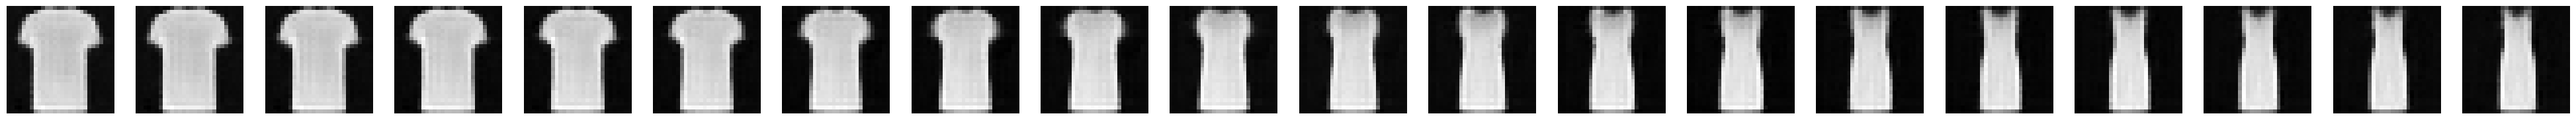

In [21]:
num_interpolation_imgs = 20

img_class_A = get_img_of_class(0, test_dataset)
img_class_B = get_img_of_class(3, test_dataset)

# Add batch dimension
img_class_A = img_class_A.unsqueeze(0).to(device)
img_class_B = img_class_B.unsqueeze(0).to(device)

# Encode
mean_vec_A, log_var_vec_A = encoder(img_class_A)
std_A = torch.exp(0.5 * log_var_vec_A)
epsilon_A = torch.randn_like(std_A)
z_A = mean_vec_A + epsilon_A * std_A

mean_vec_B, log_var_vec_B = encoder(img_class_B)
std_B = torch.exp(0.5 * log_var_vec_B)
epsilon_B = torch.randn_like(std_B)
z_B = mean_vec_B + epsilon_B * std_B

# Interpolation coefficients
a = torch.linspace(0, 1, num_interpolation_imgs).to(z_A.device).unsqueeze(1)

# Interpolate in latent space
interpolated_z = (1 - a) * z_A + a * z_B

# Decode
generated_images = decoder(interpolated_z)

# Show
show_images(generated_images)